# DCEC algroithm - MIT-BIH dataset

In [1]:
import os
import re
import sys
import glob
import numpy as np
import matplotlib.pyplot as plt
import unittest
import torch
import torchvision
import torchvision.transforms as tvtf
import pandas as pd
import copy
import utils

import umap
import umap.plot
import mit_bih
from sklearn.model_selection import train_test_split

import autoencoder
from clustering import ClusteringLayer, kmeans, calculate_predictions, target

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
plt.rcParams.update({'font.size': 12})
test = unittest.TestCase()

print(device)

# Set the seed for reproducing the results
np.random.seed(42)
torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    
# if z_dim is not a parameter then default value is 30
if not 'z_dim' in locals():
    z_dim = 30
    
print(f"z_dim {z_dim}")
    
num_clusters = 5

cuda
z_dim 30


### Now lets load the MIT-BIH dataset and plot it using umap:

In [3]:
ds_1 = pd.read_csv("data/mitbih_train.csv", header=None)
ds_2 = pd.read_csv("data/mitbih_test.csv", header=None)
ds = pd.concat([ds_1, ds_2])

df_0 = (ds[ds[187]==0]).sample(n=4000)
df_1 = (ds[ds[187]==1]).sample(n=4000, replace=True)
df_2 = (ds[ds[187]==2]).sample(n=4000)
df_3 = (ds[ds[187]==3]).sample(n=4000, replace=True)
df_4 = (ds[ds[187]==4]).sample(n=4000)

ds = pd.concat([df_0, df_1, df_2, df_3, df_4])

np.random.shuffle(ds.values)
ds = torch.tensor(ds.values).float()

in_size = ds.shape[1] - 1
print('input size =', in_size)

input size = 187


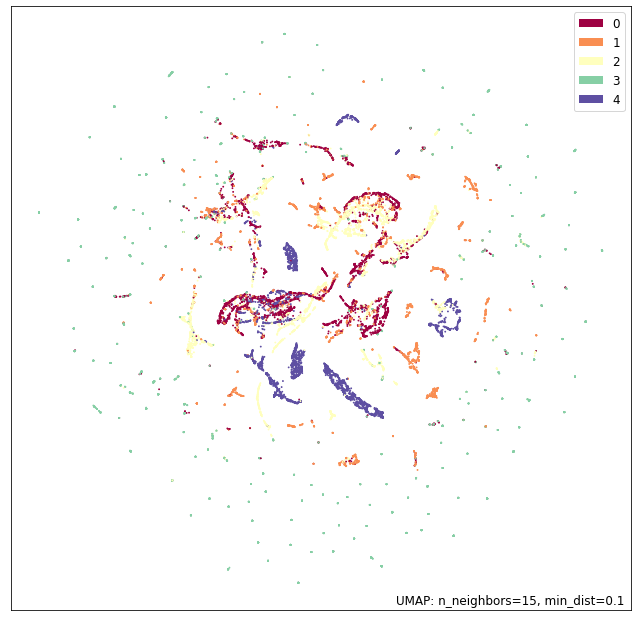

In [4]:
X = ds[:, list(range(in_size))]
y = ds[:, in_size].squeeze(-1).long()

reducer = umap.UMAP()
reducer = reducer.fit(X)
graph = umap.plot.points(reducer, labels=y)
#graph.figure.savefig("figures/MIT-BIH raw data dim=" + str(z_dim), format="pdf", bbox_inches = "tight")

In [5]:
encoder = autoencoder.Encoder(in_size, z_dim)
clustering_layer = ClusteringLayer(z_dim, num_clusters)
decoder = autoencoder.Decoder(z_dim, in_size)

AE = autoencoder.Autoencoder(encoder, decoder, clustering_layer, num_clusters)

print(AE)

Autoencoder(
  (encoder): Encoder(
    (cnn): Sequential(
      (0): Conv1d(187, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): LeakyReLU(negative_slope=0.2)
      (2): Conv1d(128, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): LeakyReLU(negative_slope=0.2)
      (4): Conv1d(64, 30, kernel_size=(3,), stride=(1,), padding=(1,))
    )
  )
  (clustering_layer): ClusteringLayer(in_features=30, out_features=5, alpha=1.0)
  (decoder): Decoder(
    (cnn): Sequential(
      (0): ConvTranspose1d(30, 64, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): LeakyReLU(negative_slope=0.2)
      (2): ConvTranspose1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (3): LeakyReLU(negative_slope=0.2)
      (4): ConvTranspose1d(128, 187, kernel_size=(3,), stride=(1,), padding=(1,))
    )
  )
)


## Preraining
**Note:** set `train` to false to skip pretraining.

In [6]:
from experiments import save_experiment
import training
import time

pretrain = False # use false to skip training

if pretrain:
    print("--- Pretraining Model ---")
    AE = AE.to(device)
    loss = torch.nn.MSELoss(size_average=True)
    # loss2 = torch.nn.KLDivLoss(size_average=False)
    #loss2 = None
    
    optimizer = torch.optim.SGD(AE.parameters(), lr=0.1, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)
    
    autoencoder_training = True # For using X as "labels"
    trainer = training.TorchTrainer(AE, loss, optimizer, scheduler, device, autoencoder_training)

    bs = 100
    early_stopping = None
    checkpoints = None
    epochs = 400
    batches = 1000

    dl = torch.utils.data.DataLoader(ds, bs, shuffle=False)
    start_time = time.time()
    fit_res = trainer.fit(dl_train=dl, dl_test=dl, num_epochs=epochs,
                          checkpoints=checkpoints, early_stopping=early_stopping,
                          print_every=50, max_batches=batches)

    end_time = time.time()

    print("--- Running Time: %s seconds ---" % (end_time - start_time))
    print("--- Saving Autoencoder ---")
    torch.save(AE.state_dict(), "./models/pretrained_MIT-BIH_dim=" + str(z_dim) + ".pt")

else:
    print("--- Skipping Pretraining & Loading Model---")
    AE = autoencoder.Autoencoder(encoder, decoder, clustering_layer, num_clusters)
    AE.load_state_dict(torch.load("./models/pretrained_MIT-BIH_dim=" + str(z_dim) + ".pt"))
    AE.eval()
    AE = AE.to(device)

--- Skipping Pretraining & Loading Model---


Now, we can move to pretraining the autoencoder for the MIT-BIH dataset.

In [7]:
print('Initializing cluster centers based on K-means')
bs = 100
dl = torch.utils.data.DataLoader(ds, bs, shuffle=False)
kmeans(AE, copy.deepcopy(dl), device)

Initializing cluster centers based on K-means


Initial target distribution

In [8]:
print('Updating target distribution')
output_distribution, labels, preds_prev = calculate_predictions(AE, copy.deepcopy(dl), device)
target_distribution = target(output_distribution)
labels = labels.squeeze(-1)
nmi = utils.metrics.nmi(labels, preds_prev)
ari = utils.metrics.ari(labels, preds_prev)
acc = utils.metrics.acc(labels, preds_prev)
print('NMI: {0:.5f}\tARI: {1:.5f}\tAcc {2:.5f}\n'.format(nmi, ari, acc))

Updating target distribution
NMI: 0.22741	ARI: 0.17879	Acc 0.31595



In [9]:
train = False # use false to skip training

if train:
    print("--- Training Model ---")
    AE = AE.to(device)
    loss = torch.nn.MSELoss(size_average=True)
    loss2 = torch.nn.KLDivLoss(size_average=False)
    
    optimizer = torch.optim.Adam(AE.parameters())
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=200, gamma=0.1)
    
    autoencoder_training = True # For using X as "labels"
    update_interval = 180
    gamma = 0.1
    trainer = training.TorchTrainer(AE, loss, optimizer, scheduler, device, autoencoder_training, loss2, update_interval, target_distribution, gamma)

    bs = 100
    early_stopping = None
    checkpoints = None
    epochs = 600
    batches = 1000

    dl = torch.utils.data.DataLoader(ds, bs, shuffle=False)
    start_time = time.time()
    fit_res = trainer.fit(dl_train=dl, dl_test=dl, num_epochs=epochs,
                          checkpoints=checkpoints, early_stopping=early_stopping,
                          print_every=50, max_batches=batches)

    end_time = time.time()

    print("--- Running Time: %s seconds ---" % (end_time - start_time))
    print("--- Saving Autoencoder ---")
    torch.save(AE.state_dict(), "./models/trained_MIT-BIH_dim=" + str(z_dim) + ".pt")

else:
    print("--- Skipping Training & Loading Model---")
    AE = autoencoder.Autoencoder(encoder, decoder, clustering_layer, num_clusters)
    AE.load_state_dict(torch.load("./models/trained_MIT-BIH_dim=" + str(z_dim) + ".pt"))
    AE.eval()
    AE = AE.to(device)

--- Skipping Training & Loading Model---


/home/amitrotner/anaconda3/envs/cs236781-hw/lib/python3.7/site-packages/sklearn/manifold/_spectral_embedding.py:236: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


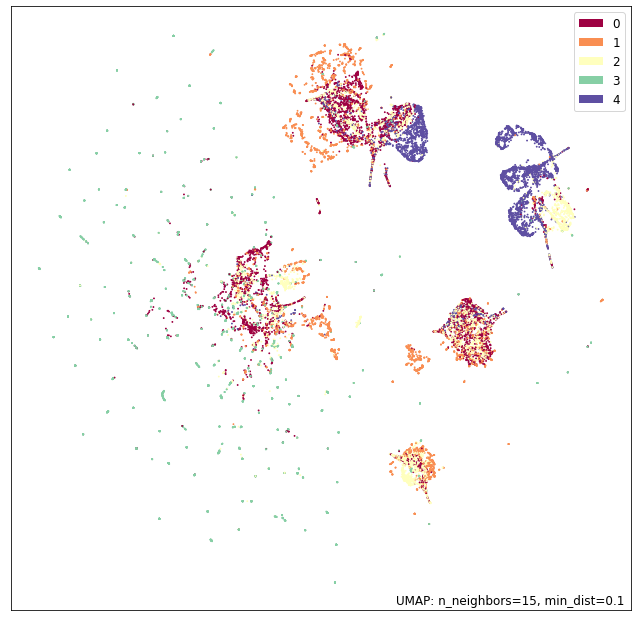

In [10]:
X = ds[:, list(range(in_size))].to(device)
y = ds[:, in_size].squeeze(-1).long()
Z = AE.encoder(X).squeeze(-1).detach().cpu().numpy()

reducer = umap.UMAP()
reducer = reducer.fit(Z)
graph = umap.plot.points(reducer, labels=y)
#graph.figure.savefig("figures/MIT-BIH clustered data dim=" + str(z_dim), format="pdf", bbox_inches = "tight")

In [11]:
Z = np.concatenate((Z, y.unsqueeze(-1)), axis=1)

ds_train, ds_test = train_test_split(Z, test_size=0.2, shuffle=True, stratify=Z[:,-1])
ds_train = torch.tensor(ds_train).float()
ds_test = torch.tensor(ds_test).float()

in_size = ds_train.shape[1] - 1
num_classes = 5
print(in_size)

30


In [12]:
from experiments import save_experiment
import time

train = False # use false to skip training

if train:
    print("--- Training Model ---")
    model = mit_bih.ConvNet(in_size, num_classes)
    model = model.to(device)
    loss = torch.nn.CrossEntropyLoss()

    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.9, 0.999), eps=1e-08)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.75)

    trainer = training.TorchTrainer(model, loss, optimizer, scheduler, device)

    bs_train = 100
    bs_test = 20
    early_stopping = 5
    checkpoints = None
    epochs = 3000
    batches = 1000

    dl_train = torch.utils.data.DataLoader(ds_train, bs_train, shuffle=False)
    dl_test = torch.utils.data.DataLoader(ds_test, bs_test, shuffle=False)
    start_time = time.time()
    fit_res = trainer.fit(dl_train=dl_train, dl_test=dl_test,
                            early_stopping=early_stopping,
                            checkpoints=checkpoints, num_epochs=epochs, max_batches=batches)

    end_time = time.time()

    print("--- Running Time: %s seconds ---" % (end_time - start_time))
    print("--- Saving Model ---")
    torch.save(model.state_dict(), "./models/MIT-BIH_CNN_after_clustering_dim=" + str(z_dim) + ".pt")
    save_experiment("MIT-BIH_CNN_after_clustering_dim=" + str(z_dim), "./results", fit_res)

else:
    print("--- Skipping Training & Loading Model ---")
    model = mit_bih.ConvNet(in_size, num_classes)
    model.load_state_dict(torch.load("./models/MIT-BIH_CNN_after_clustering_dim=" + str(z_dim) + ".pt"))
    model.eval()
    model = model.to(device)

--- Skipping Training & Loading Model ---


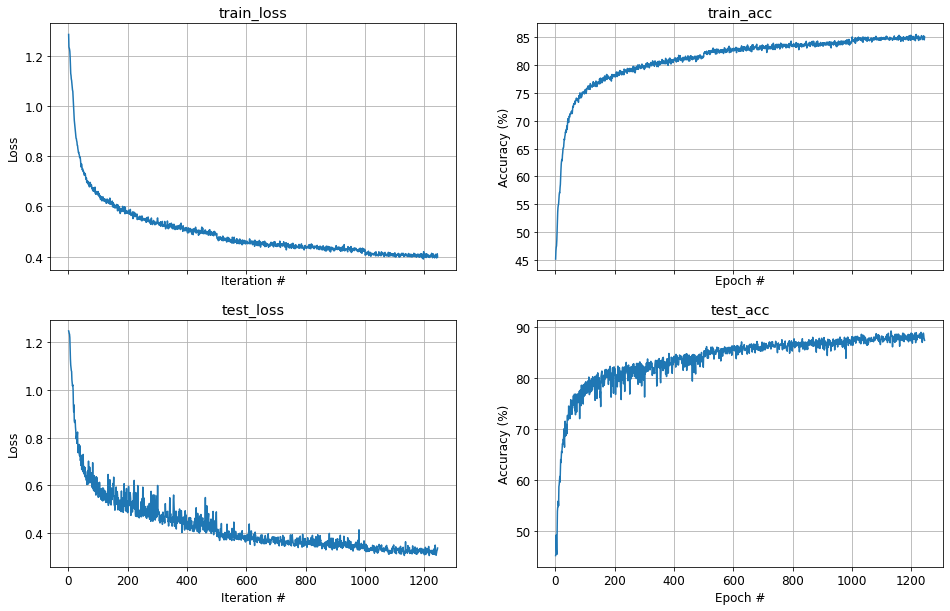

In [13]:
from experiments import load_experiment
from cs236781.plot import plot_fit

fit_res = load_experiment('results/MIT-BIH_CNN_after_clustering_dim=' + str(z_dim) + '.json')
_, _ = plot_fit(fit_res)

Normalized confusion matrix


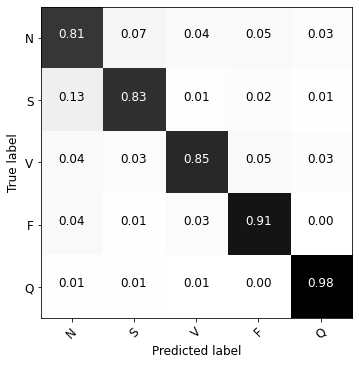

In [14]:
import itertools
from sklearn.metrics import confusion_matrix

X_test = ds_test[:,list(range(z_dim))].to(device)
y_test = ds_test[:,z_dim].unsqueeze(-1).to(device)

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix

with torch.no_grad():
    y_pred = model(X_test).cpu().numpy()
    
cnf_matrix = confusion_matrix(y_test.cpu().numpy(), y_pred.argmax(axis=1))
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['N','S','V','F','Q'], normalize=True)

#plt.savefig("figures/MIT-BIH CNN after clustering confusion matrix dim=" + str(z_dim) + ".pdf", format="pdf", bbox_inches = "tight")
plt.show() 